# Ruptura
Processamento e correção dos dados de estoque das lojas, e obtenção da quantidade de venda perdida por ruptura de estoque.

### Correção dos dados das lojas

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import timedelta

def read_data(store_name):
    try:
        #stock_df = pd.read_csv('storage_data/' + store_name + '.csv', index_col=0)
        #sales_df = pd.read_csv('data/' + store_name + '.csv', index_col=0)
        stock_df = pd.read_csv('/content/drive/MyDrive/Vendas/' + store_name + '.csv', index_col=0)
        sales_df = pd.read_csv('/content/drive/MyDrive/Saldos Processados/' + store_name + '.csv', index_col=0)

        stock_df.index = pd.to_datetime(stock_df.index)
        sales_df.index = pd.to_datetime(sales_df.index)
    
        return stock_df, sales_df
    except:
        print('Error while opening %s data' % (store_name))
        return None, None

In [ ]:
# Coisas do colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def set_nan_values(stock_df):  
    # Considera-se como uma data em que não há contagem a data onde o estoque de todos os produtos é 0
    stock_df[stock_df.index.day_of_week == 6] = np.nan # Não há contagem no domingo
    stock_df[stock_df.sum(axis=1) == 0] = np.nan # Pegar as outras datas em que não houveram contagem
    # Desconsiderar as datas em que não possuimos dados
    first_date_w_data = stock_df[stock_df.sum(axis=1) > 0].index[0]
    stock_df[:first_date_w_data] = 0 
    
    return stock_df

In [ ]:
def get_missing_dates(stock_df):
    na_rows = stock_df.isna().any(axis=1)
    missing_dates = na_rows[na_rows == True].index
    
    return missing_dates

In [ ]:
def fix_stock(stock_df, sales_df):
    stock_df = set_nan_values(stock_df)
    missing_dates = get_missing_dates(stock_df)
    
    for date in missing_dates:
        stock_df.loc[date - timedelta(days=1) : date] = stock_df.loc[date - timedelta(days=1) : date].fillna(method='ffill')
        stock_df.loc[date] -= sales_df.loc[date - timedelta(days=1)]
    
    # Corrigir estoque negativo
    return stock_df.applymap(lambda x : x if x > 0 else 0)

In [ ]:
stores = ['Ico', 'Jacobina', 'Lagoa', 'Campina Grande I', 'Bayeux',
       'Esperanca', 'Irece I', 'Mangabeira Shopping', 'Patos I', 'Matriz',
       'Patos II', 'Campina Grande III', 'Itambe', 'Campina Grande II',
       'Mangabeira', 'Aristides Lobo', 'Sape', 'Sta. Rita', 'Iguatu',
       'Pombal', 'Itaporanga', 'Mamanguape', 'Sousa I', 'Timbauba',
       'Joao Dourado', 'Goiana', 'Cuite', 'Queimadas', 'Irece II',
       'Solanea', 'Guarabira', 'Cabedelo', 'Alagoa Grande', 'AREIA',
       'Bancarios', 'Sousa II', 'Barao', 'Soledade', 'Guarabira II',
       'Goiana 2', 'Geisel', 'Picui', 'Alhandra', 'Itabaiana',
       'Lagoa Seca', 'Campina Grande IV', 'Monteiro', 'Patos III',
       'Pianco', 'Sto. Elias', 'Monteiro 2', 'Caruaru',
       'Manaira', 'CABEDELO BR', 'Patos IV']

In [ ]:
i = 0

for store in stores:
    i += 1
    
    print('(%d/%d)' % (i, len(stores)))
    print('Reading %s data' % (store))
    stock_df, sales_df = read_data(store)
    before = stock_df.sum(axis=1)
    
    print('Fixing %s data' % (store))
    stock_df = fix_stock(stock_df, sales_df)
    
    print('Saving fixed %s data' % (store))
    stock_df.to_csv('storage_data/' + store + '.csv')

In [ ]:
def get_sales_loss(store):
    stock_df, sales_df = read_data(store)
    loss_df = sales_df.copy(deep=True)
    #i = 0
    for product in sales_df.columns:
        #i += 1
        #if i % 100 == 0:
        #    print('(%d/%d)' % (i, len(sales_df.columns)))
        if sales_df[product].sum() == 0: # Tem caso onde o produto não vendeu na loja
            continue

        rolling = sales_df[product].rolling(window=7).mean().fillna(0)
        rolling[:'2019-01-01'] = 0 # Não temos dados de estoque de 2019 para trás
        loss_df[product] = [np.round(average - sales) if stock == 0 else 0 for (sales, stock, average) in zip(sales_df[product], stock_df[product], rolling)]
        loss_df[product] = loss_df[product].apply(lambda x : x if x > 0 else 0)

    return loss_df

In [ ]:
stock_df, sales_df = read_data(stores[0])
all_loss = stock_df.copy(deep=True)

for col in all_loss.columns:
    all_loss[col] = 0

In [ ]:
i = 0
for store in stores:
    i += 1
    
    print('(%d/%d)' % (i, len(stores)))
    print('Getting sales loss of %s' % (store))
    loss = get_sales_loss(store)
    
    print('Adding %s loss to general loss dataframe' % (store))
    for product in all_loss.columns:
        all_loss[product] += loss[product]
    
    print('Saving %s sales loss' % (store))
    #loss.to_csv('storage_data/loss/' + store + '.csv')
    loss.to_csv('/content/drive/MyDrive/Saldos Processados/Ruptura/' + store + '.csv')

(1/55)
Getting sales loss of Ico
Adding Ico loss to general loss dataframe
Saving Ico sales loss
(2/55)
Getting sales loss of Jacobina
Adding Jacobina loss to general loss dataframe
Saving Jacobina sales loss
(3/55)
Getting sales loss of Lagoa
Adding Lagoa loss to general loss dataframe
Saving Lagoa sales loss
(4/55)
Getting sales loss of Campina Grande I
Adding Campina Grande I loss to general loss dataframe
Saving Campina Grande I sales loss
(5/55)
Getting sales loss of Bayeux
Adding Bayeux loss to general loss dataframe
Saving Bayeux sales loss
(6/55)
Getting sales loss of Esperanca
Adding Esperanca loss to general loss dataframe
Saving Esperanca sales loss
(7/55)
Getting sales loss of Irece I
Adding Irece I loss to general loss dataframe
Saving Irece I sales loss
(8/55)
Getting sales loss of Mangabeira Shopping
Adding Mangabeira Shopping loss to general loss dataframe
Saving Mangabeira Shopping sales loss
(9/55)
Getting sales loss of Patos I
Adding Patos I loss to general loss data

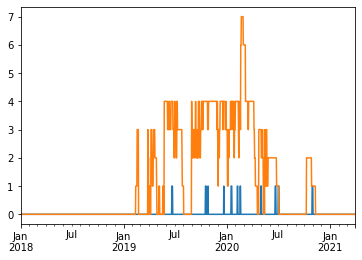

In [29]:
loss['REFRIGERADOR ROC 31 BR'].plot()
sales_df['REFRIGERADOR ROC 31 BR'].plot()

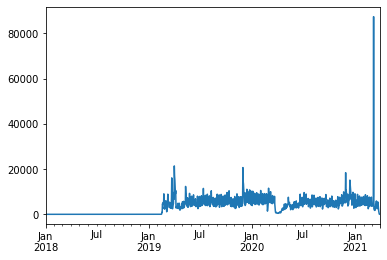

In [30]:
all_loss.to_csv('/content/drive/MyDrive/Saldos Processados/Ruptura/' + store + '.csv')

In [6]:
categories = json.load(open('subcategorias.json'))
loss = pd.read_csv('ruptura_geral.csv', index_col=0)
loss.index = pd.to_datetime(loss.index)

loss['GERAL'] = loss.sum(axis=1)
for category in categories:
    loss[category] = loss[categories[category]].sum(axis=1)

loss.to_csv('ruptura_geral.csv')